In [2]:
import numpy as np
from ncon import ncon
from numpy.linalg import qr, svd, pinv, norm
import Tools
import BoseHubbard
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.linalg import svd, expm

plt.rcParams['figure.figsize'] = [16, 9]

In [22]:
PEPS = dict(np.load("./BHNEW5swapABcorectederror_16_4_1.0_4.9_0.005_100/PEPS_00010.npz"))
GATES = BoseHubbard.TrotterGate(5, 25, 0.005, 1, 0, 0)
ifprint = True
iffast = False
ifsvdu = True
maxiter = 50
precision = 1e-20

A = PEPS['A']
B = PEPS['B']
GA = GATES['GA']
GB = GATES['GB']

d = A.shape[-1]
D = A.shape[0]
r = GA.shape[-1]
DD, DDD, DDDD = D * D, D * D * D, D * D * D * D
Dr, DDr, DDDr = D * r, D * D * r, D * D * D * r
Dd, DDd, DDDd = D * d, D * D * d, D * D * D * d

# RA, RB -<|-
AG = ncon([A, GA], ([-1, -2, -4, -5, 1], [1, -6, -3])).reshape(D, Dr, D, D, d)
Q, R = qr(AG.swapaxes(1, 2).swapaxes(2, 3).swapaxes(3, 4).reshape(DDDd, Dr), mode='reduced')
QA = Q.reshape(D, D, D, d, Dr).swapaxes(3, 4).swapaxes(2, 3).swapaxes(1, 2)
RA = R

BG = ncon([B, GB], ([-1, -2, -3, -4, 1], [1, -6, -5])).reshape(D, D, D, Dr, d)
Q, R = qr(BG.swapaxes(3, 4).reshape(DDDd, Dr), mode='reduced')
QB = Q.reshape(D, D, D, d, Dr).swapaxes(3, 4)
RB = R

# MA, MB -|>-
MA, MB = Tools.truncate2(RA @ RB.T, D)
MB = MB.T


def calc_JA(MB):
    tensors = [B, B.conj(), A, A.conj(), B, B.conj(), B, B.conj(), A, A.conj(), A, A.conj(), QA, QA.conj(), QB,
               QB.conj(), RA, RB, MB.conj()]
    connects = [[15, 14, 17, 16, 2], [15, 13, 18, 16, 2], [10, 9, 12, 14, 1], [10, 9, 11, 13, 1], [21, 19, 23, 22, 3],
                [21, 20, 23, 22, 3], [24, 26, 28, 29, 4], [25, 27, 28, 29, 4], [37, 31, 30, 26, 5], [38, 31, 30, 27, 5],
                [34, 33, 32, 36, 6], [34, 33, 32, 35, 6], [17, 41, 24, 19, 7], [18, -1, 25, 20, 7], [12, 36, 37, 40, 8],
                [11, 35, 38, 42, 8], [41, 39], [40, 39], [42, -2]]
    con_order = [15, 16, 2, 34, 33, 32, 6, 42, 35, 31, 30, 5, 39, 10, 9, 1, 28, 29, 4, 40, 21, 23, 22, 3, 36, 8, 26, 27,
                 14, 13, 37, 38, 12, 11, 17, 24, 41, 19, 18, 25, 7, 20]
    return ncon(tensors, connects, con_order)


def calc_gA(MB):
    tensors = [B, B.conj(), A, A.conj(), B, B.conj(), B, B.conj(), A, A.conj(), A, A.conj(), QA, QA.conj(), QB,
               QB.conj(), MB.conj(), MB]
    connects = [[15, 14, 17, 16, 2], [15, 13, 18, 16, 2], [10, 9, 12, 14, 1], [10, 9, 11, 13, 1], [21, 19, 23, 22, 3],
                [21, 20, 23, 22, 3], [24, 26, 28, 29, 4], [25, 27, 28, 29, 4], [37, 31, 30, 26, 5], [38, 31, 30, 27, 5],
                [34, 33, 32, 36, 6], [34, 33, 32, 35, 6], [17, -1, 24, 19, 7], [18, -3, 25, 20, 7], [12, 36, 37, 40, 8],
                [11, 35, 38, 39, 8], [39, -4], [40, -2]]
    con_order = [15, 16, 2, 10, 9, 1, 34, 33, 32, 6, 40, 31, 30, 5, 36, 28, 29, 4, 14, 13, 39, 35, 8, 26, 27, 12, 11,
                 37, 38, 17, 24, 21, 23, 22, 3, 20, 18, 25, 19, 7]
    return ncon(tensors, connects, con_order)


def calc_JB(MA):
    tensors = [B, B.conj(), A, A.conj(), B, B.conj(), B, B.conj(), A, A.conj(), A, A.conj(), QA, QA.conj(), QB,
               QB.conj(), RA, RB, MA.conj()]
    connects = [[15, 14, 17, 16, 2], [15, 13, 18, 16, 2], [10, 9, 12, 14, 1], [10, 9, 11, 13, 1], [21, 19, 23, 22, 3],
                [21, 20, 23, 22, 3], [24, 26, 28, 29, 4], [25, 27, 28, 29, 4], [37, 31, 30, 26, 5], [38, 31, 30, 27, 5],
                [34, 33, 32, 36, 6], [34, 33, 32, 35, 6], [17, 41, 24, 19, 7], [18, 42, 25, 20, 7], [12, 36, 37, 40, 8],
                [11, 35, 38, -2, 8], [41, 39], [40, 39], [42, -1]]
    con_order = [15, 16, 2, 21, 23, 22, 3, 28, 29, 4, 10, 9, 1, 42, 31, 30, 5, 20, 34, 33, 32, 6, 26, 27, 39, 41, 19, 7,
                 14, 13, 17, 18, 25, 24, 12, 40, 37, 36, 11, 38, 8, 35]
    return ncon(tensors, connects, con_order)


def calc_gB(MA):
    tensors = [B, B.conj(), A, A.conj(), B, B.conj(), B, B.conj(), A, A.conj(), A, A.conj(), QA, QA.conj(), QB,
               QB.conj(), MA.conj(), MA]
    connects = [[15, 14, 17, 16, 2], [15, 13, 18, 16, 2], [10, 9, 12, 14, 1], [10, 9, 11, 13, 1], [21, 19, 23, 22, 3],
                [21, 20, 23, 22, 3], [24, 26, 28, 29, 4], [25, 27, 28, 29, 4], [37, 31, 30, 26, 5], [38, 31, 30, 27, 5],
                [34, 33, 32, 36, 6], [34, 33, 32, 35, 6], [17, 40, 24, 19, 7], [18, 39, 25, 20, 7], [12, 36, 37, -2, 8],
                [11, 35, 38, -4, 8], [39, -3], [40, -1]]
    con_order = [15, 16, 2, 31, 30, 5, 28, 29, 4, 21, 23, 22, 3, 10, 9, 1, 26, 27, 39, 14, 13, 20, 40, 34, 33, 32, 6,
                 36, 19, 7, 25, 24, 17, 18, 12, 37, 11, 38, 35, 8]
    return ncon(tensors, connects, con_order)


def calc_error(MA, MB):
    def err(MAMBT):
        if np.all(MAMBT == 0):
            W = RA @ RB.T
        else:
            W = MAMBT - RA @ RB.T
        tensors = [B, B.conj(), A, A.conj(), B, B.conj(), B, B.conj(), A, A.conj(), A, A.conj(), QA, QA.conj(), QB,
                   QB.conj(), W, W.conj()]
        connects = [[15, 14, 17, 16, 2], [15, 13, 18, 16, 2], [10, 9, 12, 14, 1], [10, 9, 11, 13, 1],
                    [21, 19, 23, 22, 3], [21, 20, 23, 22, 3], [24, 26, 28, 29, 4], [25, 27, 28, 29, 4],
                    [37, 31, 30, 26, 5], [38, 31, 30, 27, 5], [34, 33, 32, 36, 6], [34, 33, 32, 35, 6],
                    [17, 40, 24, 19, 7], [18, 41, 25, 20, 7], [12, 36, 37, 39, 8], [11, 35, 38, 42, 8], [40, 39],
                    [41, 42]]
        con_order = [15, 16, 2, 28, 29, 4, 34, 33, 32, 6, 21, 23, 22, 3, 20, 35, 42, 41, 10, 9, 1, 31, 30, 5, 14, 13,
                     18, 11, 26, 27, 39, 25, 38, 12, 36, 8, 37, 17, 19, 7, 24, 40]
        return ncon(tensors, connects, con_order)

    MAMBT = MA @ MB.T
    return err(MAMBT) / err(np.zeros_like(MAMBT))

def calc_g():
    BB = B.swapaxes(1,0).reshape(D, DDDd)
    SB = (BB @ BB.conj().T).reshape(DD)
    AA = A.swapaxes(3,2).swapaxes(2,1).swapaxes(1,0).reshape(D, DDDd)
    SA = (AA @ AA.conj().T).reshape(DD)

    BB = B.swapaxes(0,1).swapaxes(1,2).reshape(DD,DDd)
    UB = (BB @ BB.conj().T).reshape(D,D,D,D).swapaxes(1,2).reshape(DD,DD)
    AA = A.swapaxes(4,3).swapaxes(3,2).reshape(DDd,DD).T
    UA = (AA @ AA.conj().T).reshape(D,D,D,D).swapaxes(1,2).reshape(DD,DD)

    BB = B.reshape(DD,DDd)
    DB = (BB @ BB.conj().T).reshape(D,D,D,D).swapaxes(1,2).reshape(DD,DD)
    AA = A.swapaxes(3,2).swapaxes(2,1).reshape(DD,DDd)
    DA = (AA @ AA.conj().T).reshape(D,D,D,D).swapaxes(1,2).reshape(DD,DD)

    QAp = ncon([QA,SB.reshape(D,D)],([-1,-2,-3,1,-5],[1,-4]))
    QAw = (QAp.reshape(DDDr,Dd) @ QA.reshape(DDDr,Dd).conj().T).reshape(D,Dr,D,D,Dr,D).swapaxes(1,3).swapaxes(2,3).swapaxes(3,4).reshape(DD,DDrr,DD)
    QBp = ncon([QB,SA.reshape(D,D)],([-1,1,-3,-4,-5],[1,-2]))
    QBw = (QBp.swapaxes(1,2).swapaxes(2,3).reshape(DDDr,Dd) @ QB.swapaxes(1,2).swapaxes(2,3).reshape(DDDr,Dd).conj().T).reshape(D,D,Dr,D,D,Dr).swapaxes(1,3).swapaxes(2,3).swapaxes(3,4).reshape(DD,DD,DDrr)

    env = ncon([QAw,QBw,UA,UB,DA,DB],([3,-1,6],[5,4,-2],[5,2],[2,3],[4,1],[6,1])).reshape(Dr,Dr,Dr,Dr).swapaxes(1,2)

def calc_MA(gA, JA, rc=1e-8):
    g = gA.reshape(DDr, DDr).T
    g = (g + g.conj().T) / 2
    return (pinv(g, rcond=rc, hermitian=True) @ JA.reshape(DDr)).reshape(Dr, D)


def calc_MB(gB, JB, rc=1e-8):
    g = gB.reshape(DDr, DDr).T
    g = (g + g.conj().T) / 2
    return (pinv(g, rcond=rc, hermitian=True) @ JB.reshape(DDr)).reshape(D, Dr).T


SVDUerror = calc_error(MA, MB)
if ifprint: print("\tSVDUerror:", np.abs(SVDUerror))
NTUerror = SVDUerror
if ifsvdu or SVDUerror < precision:
    PEPSNEXT = {'A': ncon([QA, MA], ([-1, 1, -3, -4, -5], [1, -2])),
                'B': ncon([QB, MB], ([-1, -2, -3, 1, -5], [1, -4])), 'GA': GA, 'GB': GB, 'SVDUerror': SVDUerror,
                'NTUerror': NTUerror}

if iffast:
    rcs = [1e-8]
else:
    rcs = [1e-6, 1e-8, 1e-10, 1e-12, 1e-14, 1e-16]
MA_best, MB_best, error_best, error_prev = MA, MB, SVDUerror, SVDUerror
for iter in range(0):
    error_prev = error_best

    gA = calc_gA(MB_best)
    JA = calc_JA(MB_best)
    for rc in rcs:
        MA_temp = calc_MA(gA, JA, rc=rc)
        error_temp = calc_error(MA_temp, MB_best)
        if ifprint: print("\t\t\t", rc, " \t", np.abs(error_temp))
        if np.abs(error_temp) < np.abs(error_best):
            MA_best = MA_temp
            error_best = error_temp
    if ifprint: print("\t\t", iter, "A error =", np.abs(error_best))

    MA_best, MB_best = Tools.truncate2(MA_best @ MB_best.T, D)
    MB_best = MB_best.T

    gB = calc_gB(MA_best)
    JB = calc_JB(MA_best)
    for rc in rcs:
        MB_temp = calc_MB(gB, JB, rc=rc)
        error_temp = calc_error(MA_best, MB_temp)
        if ifprint: print("\t\t\t", rc, " \t", np.abs(error_temp))
        if np.abs(error_temp) < np.abs(error_best):
            MB_best = MB_temp
            error_best = error_temp
    if ifprint: print("\t\t", iter, "B error =", np.abs(error_best))

    MA_best, MB_best = Tools.truncate2(MA_best @ MB_best.T, D)
    MB_best = MB_best.T

    if error_best >= error_prev:
        if ifprint: print("\tNTUerror:", np.abs(error_best), "\t\t\tCONVERGENCE")
        PEPSNEXT = {'A': ncon([QA, MA_best], ([-1, 1, -3, -4, -5], [1, -2])),
                    'B': ncon([QB, MB_best], ([-1, -2, -3, 1, -5], [1, -4])), 'GA': GA, 'GB': GB,
                    'SVDUerror': SVDUerror, 'NTUerror': error_best}
    if error_best <= precision:
        if ifprint: print("\tNTUerror:", np.abs(error_best), "\t\t\tPRECISION")
        PEPSNEXT = {'A': ncon([QA, MA_best], ([-1, 1, -3, -4, -5], [1, -2])),
                    'B': ncon([QB, MB_best], ([-1, -2, -3, 1, -5], [1, -4])), 'GA': GA, 'GB': GB,
                    'SVDUerror': SVDUerror, 'NTUerror': error_best}

PEPSNEXT = {'A': ncon([QA, MA_best], ([-1, 1, -3, -4, -5], [1, -2])),
            'B': ncon([QB, MB_best], ([-1, -2, -3, 1, -5], [1, -4])), 'GA': GA, 'GB': GB, 'SVDUerror': SVDUerror,
            'NTUerror': error_best}

	SVDUerror: 1.9252482426865937e-08


In [23]:
PEPS = dict(np.load("./BHNEW5swapABcorectederror_16_4_1.0_4.9_0.005_100/PEPS_00010.npz"))
A = PEPS['A']
B = PEPS['B']
d = A.shape[-1]
D = A.shape[0]
DD, DDD, DDDD = D * D, D * D * D, D * D * D * D
Dd, DDd, DDDd = D * d, D * D * d, D * D * D * d
DDrr = D*D*r*r

BB = B.swapaxes(1,0).reshape(D, DDDd)
SB = (BB @ BB.conj().T).reshape(DD)
AA = A.swapaxes(3,2).swapaxes(2,1).swapaxes(1,0).reshape(D, DDDd)
SA = (AA @ AA.conj().T).reshape(DD)

BB = B.swapaxes(0,1).swapaxes(1,2).reshape(DD,DDd)
UB = (BB @ BB.conj().T).reshape(D,D,D,D).swapaxes(1,2).reshape(DD,DD)
AA = A.swapaxes(4,3).swapaxes(3,2).reshape(DDd,DD).T
UA = (AA @ AA.conj().T).reshape(D,D,D,D).swapaxes(1,2).reshape(DD,DD)

BB = B.reshape(DD,DDd)
DB = (BB @ BB.conj().T).reshape(D,D,D,D).swapaxes(1,2).reshape(DD,DD)
AA = A.swapaxes(3,2).swapaxes(2,1).reshape(DD,DDd)
DA = (AA @ AA.conj().T).reshape(D,D,D,D).swapaxes(1,2).reshape(DD,DD)

QAp = ncon([QA,SB.reshape(D,D)],([-1,-2,-3,1,-5],[1,-4]))
QAw = (QAp.reshape(DDDr,Dd) @ QA.reshape(DDDr,Dd).conj().T).reshape(D,Dr,D,D,Dr,D).swapaxes(1,3).swapaxes(2,3).swapaxes(3,4).reshape(DD,DDrr,DD)
QBp = ncon([QB,SA.reshape(D,D)],([-1,1,-3,-4,-5],[1,-2]))
QBw = (QBp.swapaxes(1,2).swapaxes(2,3).reshape(DDDr,Dd) @ QB.swapaxes(1,2).swapaxes(2,3).reshape(DDDr,Dd).conj().T).reshape(D,D,Dr,D,D,Dr).swapaxes(1,3).swapaxes(2,3).swapaxes(3,4).reshape(DD,DD,DDrr)

env = ncon([QAw,QBw,UA,UB,DA,DB],([3,-1,6],[5,4,-2],[5,2],[2,3],[4,1],[6,1])).reshape(Dr,Dr,Dr,Dr).swapaxes(1,2)

In [28]:
gA_env = ncon([env,MB,MB.conj()],([-1,1,-3,2],[1,-2],[2,-4]))
gA = calc_gA(MB)
np.linalg.norm(gA-gA_env)

5.609282912946118e-16

In [30]:
gB_env = ncon([env,MA,MA.conj()],([1,-2,2,-4],[1,-1],[2,-3]))
gB = calc_gB(MA)
np.linalg.norm(gB-gB_env)

5.033187355588399e-16

In [18]:
def truncate3(A, k=-1):
    u, s, vh = svd(A, full_matrices=False)
    if k <= 0 or k >= s.shape[0]:
        return u, s, vh
    else:
        s = s[:k]
        u = (u.T[:k]).T
        vh = (vh[:k])
        return u, s, vh

def truncate2(A, k=-1):
    # A = X1 @ X2.T
    u, s, vh = truncate3(A, k)
    return u @ np.diag(np.sqrt(s)), np.diag(np.sqrt(s)) @ vh
Dr,D=10,5
A = np.random.randn(Dr,D)
B = np.random.randn(D,Dr)
Ap,Bp = truncate2(A @ B, D)
print(np.linalg.norm(Ap-A))
print(np.linalg.norm(Bp-B))
print(np.linalg.norm(Ap@Bp-A@B))

9.36250704326673
9.283510285901196
9.654155280063463e-14


In [23]:
U, s, Vh = svd(RA @ RB.T)

In [28]:
s[:8]

array([0.81541928, 0.06803148, 0.06797518, 0.02559697, 0.02557727,
       0.00400038, 0.00148712, 0.00132803])

In [51]:
A, B = np.random.randn(13, 5), np.random.randn(13, 5)
a, b = Tools.truncate2(A @ B.T, 5)
b = b.T
a.shape

(13, 5)

In [50]:
A, B = np.random.randn(13, 5), np.random.randn(13, 5)
k = 5
u, s, vh = svd(A @ B.T, full_matrices=False)
sp = s[:k]
up = (u.T[:k]).T
vhp = (vh[:k])
a, b = up @ np.diag(np.sqrt(sp)), np.diag(np.sqrt(sp)) @ vhp
b = b.T
a.shape

(13, 5)

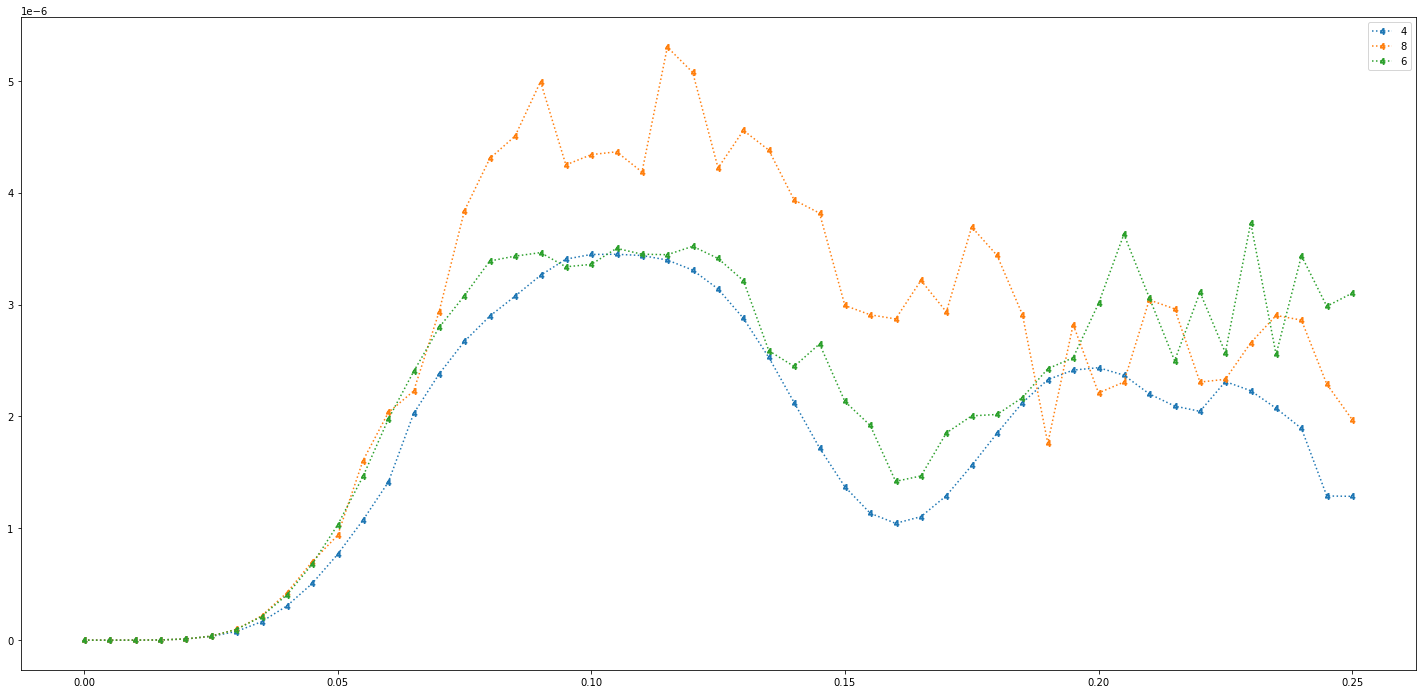

50


In [14]:
from ncon import ncon
from numpy.linalg import qr, svd, pinv, norm
import Tools
import BoseHubbard
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = [25, 12]

colors = ['C' + str(x) for x in range(10)]
# for n,dir in enumerate(['./BHNEW5_16_4_1.0_17.5_0.005_50','./BHNEW5_32_8_1.0_17.5_0.005_50','./BHNEW5_24_6_1.0_17.5_0.005_50']):
for n, dir in enumerate(
        ['./BHNEW5_16_4_1.0_4.9_0.005_50', './BHNEW5_32_8_1.0_4.9_0.005_50', './BHNEW5_24_6_1.0_4.9_0.005_50']):
    # for n,dir in enumerate(['./BHNEW4_16_4_1.0_70.0_0.0005_10000']):
    ds = []
    imax = 0
    E_AB_WE_aah, E_AB_NS_aah = [], []
    E_BA_WE_aah, E_BA_NS_aah = [], []
    E_AB_WE_aha, E_AB_NS_aha = [], []
    E_BA_WE_aha, E_BA_NS_aha = [], []
    N0_A, N1_A, N2_A, N3_A, N4_A, N0_B, N1_B, N2_B, N3_B, N4_B = [], [], [], [], [], [], [], [], [], []
    E_A_N, E_B_N, E_A_NN, E_B_NN = [], [], [], []
    aa, ts, yerr = [], [], []
    NTUerrs, CTMerrs = [], []

    SPECS = dict(np.load(dir + "/SPECS.npz"))
    for i in range(26 * 233):
        try:
            dist = 1
            env = dict(np.load(dir + "/RHOA_{:05d}.npz".format(i)))
            corrAAH_WE = dict(np.load(dir + "/CORR_AAH_WE_{:05d}.npz".format(i)))
            corrAHA_WE = dict(np.load(dir + "/CORR_AHA_WE_{:05d}.npz".format(i)))
            corrAAH_NS = dict(np.load(dir + "/CORR_AAH_NS_{:05d}.npz".format(i)))
            corrAHA_NS = dict(np.load(dir + "/CORR_AHA_NS_{:05d}.npz".format(i)))
            corrNN_NS = dict(np.load(dir + "/CORR_NN_NS_{:05d}.npz".format(i)))
            PEPS = dict(np.load(dir + ('/PEPS_{:05d}.npz'.format(i))))
        except:
            continue
        ts.append(i * PEPS['dt'])

        yerr.append(env['error'].real)
        E_AB_WE_aha.append(corrAHA_WE['corA'][dist])
        E_AB_WE_aah.append(corrAAH_WE['corA'][dist])
        E_BA_WE_aha.append(corrAHA_WE['corB'][dist])
        E_BA_WE_aah.append(corrAAH_WE['corB'][dist])
        E_AB_NS_aha.append(corrAHA_NS['corA'][dist])
        E_AB_NS_aah.append(corrAAH_NS['corA'][dist])
        E_BA_NS_aha.append(corrAHA_NS['corB'][dist])
        E_BA_NS_aah.append(corrAAH_NS['corB'][dist])
        E_A_N.append(np.trace(env['rhoA'] @ np.diag(np.arange(0, PEPS['A'].shape[-1]))))
        E_B_N.append(np.trace(env['rhoB'] @ np.diag(np.arange(0, PEPS['A'].shape[-1]))))
        E_A_NN.append(np.trace(env['rhoA'] @ np.diag(np.arange(0, PEPS['A'].shape[-1]) ** 2)))
        E_B_NN.append(np.trace(env['rhoB'] @ np.diag(np.arange(0, PEPS['A'].shape[-1]) ** 2)))
        N0_A.append(env['rhoA'][0, 0])
        N0_B.append(env['rhoB'][0, 0])
        N1_A.append(env['rhoA'][1, 1])
        N1_B.append(env['rhoB'][1, 1])
        N2_A.append(env['rhoA'][2, 2])
        N2_B.append(env['rhoB'][2, 2])
        N3_A.append(env['rhoA'][3, 3])
        N3_B.append(env['rhoB'][3, 3])
        N4_A.append(env['rhoA'][4, 4])
        N4_B.append(env['rhoB'][4, 4])
        NTUerrs.append((np.sqrt(np.abs(PEPS['NTUerror'])) / PEPS['dt']))
        CTMerrs.append(env['error'])
        imax = i

    ts = np.array(ts)
    yerr = np.array(yerr)
    E_A_N = np.array(E_A_N)
    E_B_N = np.array(E_B_N)
    E_A_NN = np.array(E_A_NN)
    E_B_NN = np.array(E_B_NN)
    E_AB_WE_aha = np.array(E_AB_WE_aha)
    E_AB_WE_aah = np.array(E_AB_WE_aah)
    E_BA_WE_aha = np.array(E_BA_WE_aha)
    E_BA_WE_aah = np.array(E_BA_WE_aah)
    E_AB_NS_aha = np.array(E_AB_NS_aha)
    E_AB_NS_aah = np.array(E_AB_NS_aah)
    E_BA_NS_aha = np.array(E_BA_NS_aha)
    E_BA_NS_aah = np.array(E_BA_NS_aah)
    N0_A = np.array(N0_A)
    N0_B = np.array(N0_B)
    N1_A = np.array(N1_A)
    N1_B = np.array(N1_B)
    N2_A = np.array(N2_A)
    N2_B = np.array(N2_B)
    N3_A = np.array(N3_A)
    N3_B = np.array(N3_B)
    N4_A = np.array(N4_A)
    N4_B = np.array(N4_B)
    NTUerrs = np.array(NTUerrs)

    Csp1 = (
                       E_BA_NS_aha + E_BA_NS_aah + E_AB_NS_aha + E_AB_NS_aah + E_BA_WE_aha + E_BA_WE_aah + E_AB_WE_aha + E_AB_WE_aah).real / 4
    VarN = (E_A_NN + E_B_NN - 2 * E_A_N - 2 * E_B_N + 2).real / 2
    NNmN = (E_A_NN + E_B_NN - E_A_N - E_B_N).real / 2
    N = (E_A_N + E_B_N).real / 2 - 1
    energy = 25 * NNmN - Csp1

    # plt.plot(ts,(N0_A+N0_B).real,marker='$0$', color=colors[n],linestyle=':',label=dir.split('_')[2])
    # plt.plot(ts,(N1_A+N1_B).real-2,marker='$1$', color=colors[n],linestyle=':',label=dir.split('_')[2])
    # plt.plot(ts,(N2_A+N2_B).real,marker='$2$', color=colors[n],linestyle=':',label=dir.split('_')[2])
    # plt.plot(ts,(N3_A+N3_B).real,marker='$3$', color=colors[n],linestyle=':',label=dir.split('_')[2])
    plt.plot(ts, (N4_A + N4_B).real, marker='$4$', color=colors[n], linestyle=':', label=dir.split('_')[2])

    # plt.plot(ts,Csp1,label='C^sp_1 '+dir.split('_')[2],marker='$C$', color=colors[n],linestyle=':')  # plt.plot(ts,VarN,label='VarN '+dir.split('_')[2],marker='$V$', color=colors[n],linestyle=':')  # plt.plot(ts,19.6/2*NNmN,label='NNmN '+dir.split('_')[2],marker='$V$', color=colors[n],linestyle=':')  # plt.plot(ts,100*N,label='NNmN '+dir.split('_')[2],marker='$N$', color=colors[n],linestyle=':')  # plt.plot(ts,energy,label='Energy '+dir.split('_')[2],marker='$E$', color=colors[n],linestyle=':')  # plt.plot(ts,len(ts)*[0])  # plt.plot(ts, (E_A_N+E_B_N).real/2,label='N'+dir.split('_')[2],marker='$N$', color='C4',linestyle=':')
plt.legend()
plt.show()
print(imax)

In [151]:
from scipy.linalg import expm

d = 3
U = 1
dt = 1
a = np.diag(np.sqrt(np.arange(1, d)), k=1)
ah = a.T
n = ah @ a
nn = n @ n
I = np.eye(d)
HU = U / 2 * (nn - n)

GU = expm(-1j * dt / 2 * HU)

In [154]:
GU

array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        ],
       [0.        +0.j        , 1.        +0.j        ,
        0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.87758256-0.47942554j]])

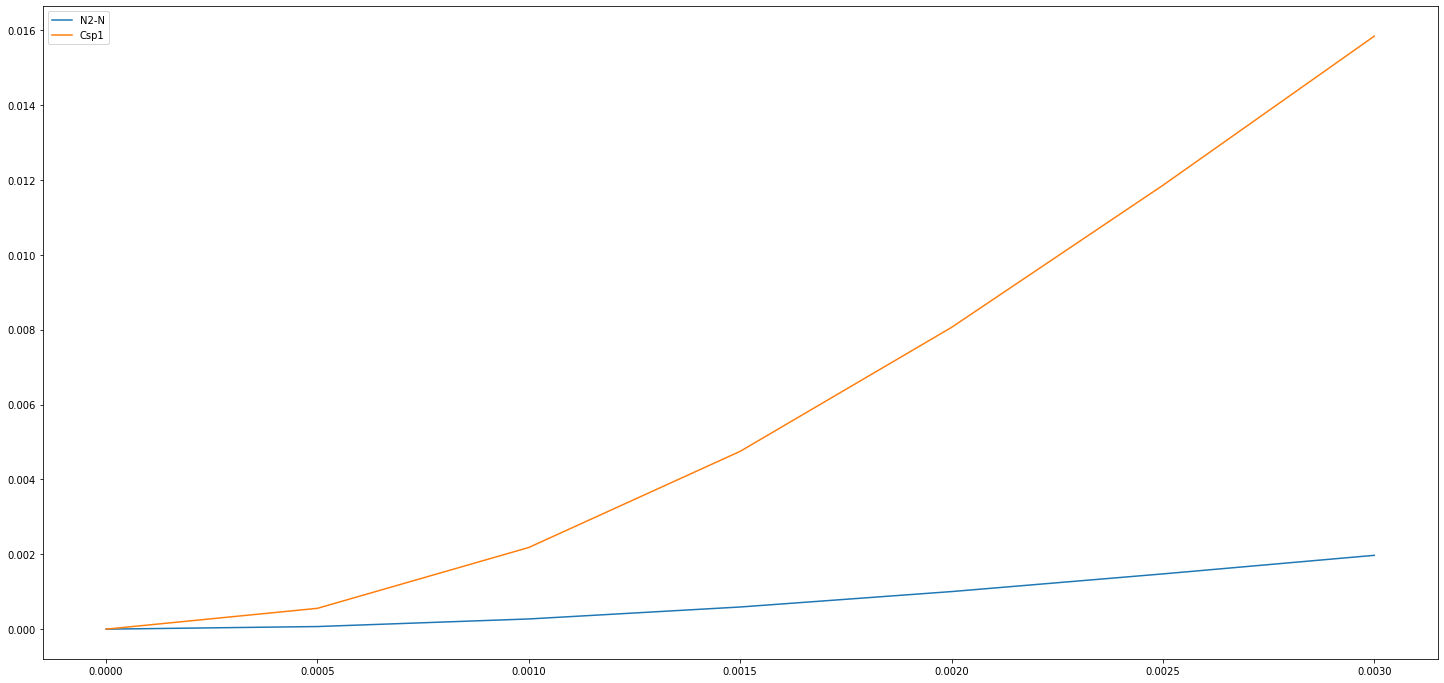

0.03


In [38]:
from ncon import ncon
from numpy.linalg import qr, svd, pinv, norm
import Tools
import BoseHubbard
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = [25, 12]

colors = ['C' + str(x) for x in range(10)]
# for n,dir in enumerate(['./BHNEW4_20_5_1.0_8.75_0.005_100']):
# for n,dir in enumerate(['./BHNEW4_24_6_1.0_8.75_0.005_50']):
for n, dir in enumerate(['./BHNEW4_16_4_1.0_70.0_0.0005_10000']):
    ds = []
    imax = 0
    E_AB_WE_aah, E_AB_NS_aah = [], []
    E_BA_WE_aah, E_BA_NS_aah = [], []
    E_AB_WE_aha, E_AB_NS_aha = [], []
    E_BA_WE_aha, E_BA_NS_aha = [], []
    N0_A, N1_A, N2_A, N3_A, N4_A, N0_B, N1_B, N2_B, N3_B, N4_B = [], [], [], [], [], [], [], [], [], []
    E_A_N, E_B_N, E_A_NN, E_B_NN = [], [], [], []
    aa, ts, yerr = [], [], []
    NTUerrs, CTMerrs = [], []

    SPECS = dict(np.load(dir + "/SPECS.npz"))
    for i in range(21 * 200):
        try:
            dist = 1
            env = dict(np.load(dir + "/RHOA_{:05d}.npz".format(i)))
            corrAAH_WE = dict(np.load(dir + "/CORR_AAH_WE_{:05d}.npz".format(i)))
            corrAHA_WE = dict(np.load(dir + "/CORR_AHA_WE_{:05d}.npz".format(i)))
            corrAAH_NS = dict(np.load(dir + "/CORR_AAH_NS_{:05d}.npz".format(i)))
            corrAHA_NS = dict(np.load(dir + "/CORR_AHA_NS_{:05d}.npz".format(i)))
            corrNN_NS = dict(np.load(dir + "/CORR_NN_NS_{:05d}.npz".format(i)))
            PEPS = dict(np.load(dir + ('/PEPS_{:05d}.npz'.format(i))))
        except:
            continue
        ts.append(i * PEPS['dt'])

        yerr.append(env['error'].real)
        E_AB_WE_aha.append(corrAHA_WE['corA'][dist])
        E_AB_WE_aah.append(corrAAH_WE['corA'][dist])
        E_BA_WE_aha.append(corrAHA_WE['corB'][dist])
        E_BA_WE_aah.append(corrAAH_WE['corB'][dist])
        E_AB_NS_aha.append(corrAHA_NS['corA'][dist])
        E_AB_NS_aah.append(corrAAH_NS['corA'][dist])
        E_BA_NS_aha.append(corrAHA_NS['corB'][dist])
        E_BA_NS_aah.append(corrAAH_NS['corB'][dist])
        E_A_N.append(np.trace(env['rhoA'] @ np.diag(np.arange(0, PEPS['A'].shape[-1]))))
        E_B_N.append(np.trace(env['rhoB'] @ np.diag(np.arange(0, PEPS['A'].shape[-1]))))
        E_A_NN.append(np.trace(env['rhoA'] @ np.diag(np.arange(0, PEPS['A'].shape[-1]) ** 2)))
        E_B_NN.append(np.trace(env['rhoB'] @ np.diag(np.arange(0, PEPS['A'].shape[-1]) ** 2)))
        N0_A.append(env['rhoA'][0, 0])
        N0_B.append(env['rhoB'][0, 0])
        N1_A.append(env['rhoA'][1, 1])
        N1_B.append(env['rhoB'][1, 1])
        N2_A.append(env['rhoA'][2, 2])
        N2_B.append(env['rhoB'][2, 2])
        N3_A.append(env['rhoA'][3, 3])
        N3_B.append(env['rhoB'][3, 3])
        N4_A.append(env['rhoA'][4, 4])
        N4_B.append(env['rhoB'][4, 4])
        NTUerrs.append((np.sqrt(np.abs(PEPS['NTUerror'])) / PEPS['dt']))
        CTMerrs.append(env['error'])
        imax = i

    ts = np.array(ts)
    yerr = np.array(yerr)
    E_A_N = np.array(E_A_N)
    E_B_N = np.array(E_B_N)
    E_A_NN = np.array(E_A_NN)
    E_B_NN = np.array(E_B_NN)
    N0_A = np.array(N0_A)
    N0_B = np.array(N0_B)
    N1_A = np.array(N1_A)
    N1_B = np.array(N1_B)
    N2_A = np.array(N2_A)
    N2_B = np.array(N2_B)
    N3_A = np.array(N3_A)
    N3_B = np.array(N3_B)
    N4_A = np.array(N4_A)
    N4_B = np.array(N4_B)
    E_AB_WE_aha = np.array(E_AB_WE_aha)
    E_AB_WE_aah = np.array(E_AB_WE_aah)
    E_BA_WE_aha = np.array(E_BA_WE_aha)
    E_BA_WE_aah = np.array(E_BA_WE_aah)
    E_AB_NS_aha = np.array(E_AB_NS_aha)
    E_AB_NS_aah = np.array(E_AB_NS_aah)
    E_BA_NS_aha = np.array(E_BA_NS_aha)
    E_BA_NS_aah = np.array(E_BA_NS_aah)
    NTUerrs = np.array(NTUerrs)
    CTMerrs = np.array(CTMerrs)

    Csp1 = (
                       E_BA_NS_aha + E_BA_NS_aah + E_AB_NS_aha + E_AB_NS_aah + E_BA_WE_aha + E_BA_WE_aah + E_AB_WE_aha + E_AB_WE_aah).real / 4
    VarN = (E_A_NN + E_B_NN - 2 * E_A_N - 2 * E_B_N + 2).real / 2
    NNmN = (E_A_NN + E_B_NN - E_A_N - E_B_N).real / 2

    # plt.plot(ts, (N0_A + N0_B).real/2, label='N0 '+dir.split('_')[2], marker='$0$', color='C0', linestyle=':')  # plt.plot(ts, (N1_A + N1_B).real/2 - 1, label='N1 '+dir.split('_')[2], marker='$1$', color='C1', linestyle=':')  # plt.plot(ts, (N2_A + N2_B).real/2, label='N2 '+dir.split('_')[2], marker='$2$', color='C2', linestyle=':')  # plt.plot(ts, (N3_A + N3_B).real/2, label='N3 '+dir.split('_')[2], marker='$3$', color='C3', linestyle=':')  # plt.plot(ts, (N4_A + N4_B).real/2, label='N4 '+dir.split('_')[2], marker='$4$', color='C4', linestyle=':')

    # plt.plot(ts,70/4*(N2_A+N2_B+3*N3_A+3*N3_B+6*N4_A+6*N4_B).real,label='N2-N')

    # plt.plot(ts,Csp1,label='Csp1')

plt.legend()
plt.show()
print(imax * 0.005)

In [32]:
CTMerrs

array([0.00000000e+00, 5.11536518e-15, 9.95371424e-15, 1.83279650e-13,
       4.05272769e-14, 1.86214831e-16, 1.20412819e-16, 2.48144995e-13,
       2.20378799e-13, 7.98108059e-14, 9.61297640e-14, 2.23376063e-13,
       7.59435132e-16, 1.41199937e-13, 1.78468680e-13, 8.10383142e-13,
       2.65806684e-13, 7.52003701e-13, 1.23907955e-13, 1.97577418e-13,
       5.09228022e-13, 3.18677602e-13, 2.11580254e-11, 4.54011794e-13,
       5.92277759e-13, 3.43441630e-13, 4.77735688e-13, 8.58645778e-13,
       2.90400642e-13, 3.70022913e-13, 8.75356673e-13, 3.61688574e-13,
       7.35876776e-13, 2.81711270e-13, 1.66584946e-13, 1.08021052e-08,
       7.34035355e-13, 3.65009332e-08, 2.16887577e-09, 4.52611018e-08,
       4.59216510e-10, 2.55879148e-13, 7.04057700e-10, 6.14364147e-11,
       6.68763815e-13, 7.79244166e-13, 1.04296130e-09, 8.57838893e-08,
       8.12119450e-13, 2.87956377e-08, 3.99157928e-13])

In [101]:
SPECS['J'] * Csp1

array([0.00000000e+00, 7.99894172e-10, 3.19829703e-09, 7.19137163e-09,
       1.27727299e-08, 1.99334429e-08, 2.86620549e-08, 3.89446021e-08,
       5.07646346e-08, 6.41032427e-08, 7.89390876e-08, 9.52484351e-08,
       1.13005194e-07, 1.32180956e-07, 1.52745046e-07, 1.74664564e-07,
       1.97904444e-07, 2.22427507e-07, 2.48194522e-07, 2.75164267e-07,
       3.03293595e-07, 3.32537506e-07, 3.62849216e-07, 3.94180233e-07,
       4.26480432e-07, 4.59698142e-07, 4.93780220e-07, 5.28672143e-07,
       5.64318090e-07, 6.00661036e-07, 6.37642840e-07, 6.75204338e-07,
       7.13285440e-07, 7.51825225e-07, 7.90762036e-07, 8.30033584e-07,
       8.69577042e-07, 9.09329148e-07, 9.49226308e-07, 9.89204695e-07,
       1.02920035e-06, 1.06914929e-06, 1.10898761e-06, 1.14865157e-06,
       1.18807772e-06, 1.22720299e-06, 1.26596477e-06, 1.30430107e-06,
       1.34215056e-06, 1.37945267e-06, 1.41614775e-06, 1.45217707e-06,
       1.48748301e-06, 1.52200908e-06, 1.55570005e-06, 1.58850201e-06,
      